<a href="https://colab.research.google.com/github/giovanni-gatti/DCGAN_CelebA/blob/main/DCGAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Synthesis using Deep Convolutional GANs
This project aims at training a Deep Convolutional GAN (DCGAN) on the CelebA (CelebFaces Attributes) dataset.


## Libraries

In [ ]:
!pip install wandb --quiet

In [ ]:
import os
import gc
import wandb
import torch
import torchvision
import torch.utils.data
from torchsummary import summary
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Check the status of the GPU:

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
!nvidia-smi

Mon Jun 12 14:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connect to Google Drive to save model checkpoints:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists('/content/drive/MyDrive/thesis/DCGAN'):
   os.mkdir('/content/drive/MyDrive/thesis/DCGAN')

In [ ]:
if not os.path.exists('/content/drive/MyDrive/thesis/images'):
   os.mkdir('/content/drive/MyDrive/thesis/images')

## Dataset

Set up the configurations dictionary:

In [ ]:
config = {
    'batch_size' : 128,
    'num_workers': 4,
    'image_size' : 64,
    'latent_size': 128,
    'epochs'     : 20,
    'init_lr_G'  : 0.0003,
    'init_lr_D'  : 0.0002,
    'adam_beta'  : 0.5,
    'gamma'      : 0.7,
    'step_size'  : 20
}

Set up the image pre-processing steps:

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((config['image_size'], config['image_size'])),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

Connect to Kaggle to download the data:

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"","key":""}')
    # Insert kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!mkdir '/content/data'

!kaggle datasets download -d jessicali9530/celeba-dataset --force

In [ ]:
!unzip -qo 'celeba-dataset.zip' -d '/content/data'

In [ ]:
train_dir  = '/content/data/img_align_celeba/'

train_data = torchvision.datasets.ImageFolder(
    root      = train_dir,
    transform = train_transforms
)

In [ ]:
print('dataset', train_data)

dataset Dataset ImageFolder
    Number of datapoints: 202599
    Root location: /content/data/img_align_celeba/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = config['num_workers'],
    pin_memory  = True
)

Visualize a training data sample:

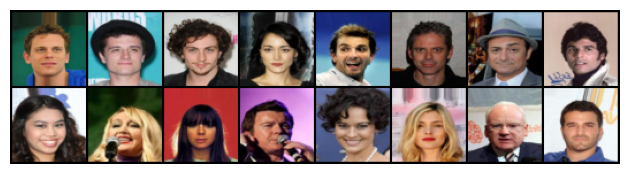

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize= (8,2))
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(DEVICE)[:16], padding= 2, normalize= True).cpu(),(1,2,0)))
# plt.savefig('/content/drive/MyDrive/thesis/real.png')

In [ ]:
for i, data in enumerate(train_loader, 0):
    print(data[0].shape)
    break

torch.Size([128, 3, 64, 64])


## Model

Set up the weight initialization function:

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

Create a custom module to add Gaussian noise to a vector:

In [ ]:
class GaussianNoise(torch.nn.Module):
    def __init__(self, mean= 0.0, std= 1.0, p= 1.0):
        super().__init__()
        self.mean = mean
        self.std  = std
        self.p    = p

    def forward(self, x):
        if (torch.rand(1).item() > self.p):
            return x
        else:
            noise = torch.empty_like(x).normal_(mean= self.mean, std= self.std)
            return x + noise.to(DEVICE)


Modular implementation of the generator network:

In [ ]:
class GeneratorBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride= 1, padding= 0):
        super().__init__()

        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias= False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout2d(0.2)
        )

    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, latent_size= 128, feature_size= 128, num_channels= 3):
        super().__init__()

        self.conv = torch.nn.Sequential(
            GeneratorBlock(latent_size, feature_size*8, 4, 1, 0),
            GeneratorBlock(feature_size*8, feature_size*4, 4, 2, 1),
            GeneratorBlock(feature_size*4, feature_size*2, 4, 2, 1),
            GeneratorBlock(feature_size*2, feature_size, 4, 2, 1),

            torch.nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias= False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        out = self.conv(x)
        return out

Modular implementation of the discriminator network:

In [ ]:
class DiscriminatorBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride= 1, padding= 0, dropout= 0.2, std= 0.1):
        super().__init__()

        self.block = torch.nn.Sequential(
            GaussianNoise(std= std),
            torch.nn.utils.spectral_norm(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias= False)),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout2d(dropout)
        )

    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self, feature_size= 128, num_channels= 3, std= 0.1):
        super().__init__()

        self.std  = std

        self.conv = torch.nn.Sequential(

            DiscriminatorBlock(num_channels, feature_size, 4, 2, 1, dropout= 0.3, std= self.std),
            DiscriminatorBlock(feature_size, feature_size*2, 4, 2, 1, dropout= 0.3, std= self.std),
            DiscriminatorBlock(feature_size*2, feature_size*4, 4, 2, 1, dropout= 0.3, std= self.std),
            DiscriminatorBlock(feature_size*4, feature_size*8, 4, 2, 1, dropout= 0.3, std= self.std),

            GaussianNoise(std= self.std),
            torch.nn.utils.spectral_norm(torch.nn.Conv2d(feature_size*8, 1, 4, 1, 0, bias= False)),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        return out

Initialize the generator network:

In [ ]:
G = Generator().to(DEVICE)
G.apply(init_weights)
print(G)
summary(G, (config['latent_size'], 1, 1))

Generator(
  (conv): Sequential(
    (0): GeneratorBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout2d(p=0.2, inplace=False)
      )
    )
    (1): GeneratorBlock(
      (block): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout2d(p=0.2, inplace=False)
      )
    )
    (2): GeneratorBlock(
      (block): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout2d(p=0.2, inplace=False)
      )
    )

Initialize the discriminator network:

In [ ]:
D = Discriminator().to(DEVICE)
D.apply(init_weights)
print(D)
summary(D, (3, 64, 64))

Discriminator(
  (conv): Sequential(
    (0): DiscriminatorBlock(
      (block): Sequential(
        (0): GaussianNoise()
        (1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Dropout2d(p=0.3, inplace=False)
      )
    )
    (1): DiscriminatorBlock(
      (block): Sequential(
        (0): GaussianNoise()
        (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.2)
        (4): Dropout2d(p=0.3, inplace=False)
      )
    )
    (2): DiscriminatorBlock(
      (block): Sequential(
        (0): GaussianNoise()
        (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(512, eps=1e-05

## Training

Set up the optimizers and the loss function:

In [ ]:
criterion  = torch.nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr= config['init_lr_D'], betas= (config['adam_beta'], 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr= config['init_lr_G'], betas= (config['adam_beta'], 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size= config['step_size'], gamma= config['gamma'])
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size= config['step_size'], gamma= config['gamma'])

Define a fixed latent vector to visualize training progress:

In [ ]:
benchmark  = torch.randn(64, config['latent_size'], 1, 1, device= DEVICE)

Set up the functions to generate the labels (allowing for one-sided label smoothing) and to sample the latent vectors:

In [ ]:
def real_label(size, fill_value= 1):
    label = torch.full((size,), fill_value)
    return label

def fake_label(size):
    label = torch.zeros(size)
    return label

In [ ]:
def generate_noise(size):
    noise = torch.randn(size, config['latent_size'], 1, 1)
    return noise

Auxiliary function to plot the generated images:

In [ ]:
def plot_img(img, index):
    fig = plt.figure(figsize= (8,8))
    plt.axis("off")
    plt.imshow(np.transpose(img.cpu(), (1,2,0)))
    save_path = '/content/drive/MyDrive/thesis/images7/img_' + str(index) + '.png'
    # plt.savefig(save_path)
    plt.show()
    print()

Connect to WandB to track training metrics and visualize progress:

In [ ]:
wandb.login(key="")  # Insert wandb key here

In [ ]:
run = wandb.init(
    name    = "DCGAN_CelebA_v3",
    reinit  = True,
    # id     = "r670acz9",
    # resume = "must",
    project = "thesis",
    config  = config
)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

2128

Define the training function:

In [ ]:
def train(G, D, dataloader, optimizerD, optimizerG, criterion, epoch):
    G.train()
    D.train()

    tlossG, tlossD = 0, 0
    tD_x, tD_G_z   = 0, 0
    batch_bar      = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (data, _) in enumerate(dataloader):

        batch_size = data.shape[0]

        D.zero_grad()
        labels              = real_label(batch_size, 0.9)
        real_images, labels = data.to(DEVICE), labels.to(DEVICE)
        outputs             = D(real_images).view(-1)
        lossD_real          = criterion(outputs, labels)
        lossD_real.backward()
        D_x                 = outputs.mean().item()

        z                   = generate_noise(batch_size).to(DEVICE)
        labels              = fake_label(batch_size).to(DEVICE)
        generated_images    = G(z)
        outputs             = D(generated_images.detach()).view(-1)
        lossD_generated     = criterion(outputs, labels)
        lossD_generated.backward()
        D_G_z               = outputs.mean().item()

        lossD = lossD_real + lossD_generated
        optimizerD.step()

        G.zero_grad()
        z                   = generate_noise(batch_size).to(DEVICE)
        labels              = real_label(batch_size, 0.9).to(DEVICE)
        generated_images    = G(z)
        outputs             = D(generated_images).view(-1)
        lossG               = criterion(outputs, labels)
        lossG.backward()

        optimizerG.step()

        tlossG += lossG.item()
        tlossD += lossD.item()
        tD_x   += D_x
        tD_G_z += D_G_z

        batch_bar.set_postfix(
            lossG        = "{:.04f}".format(float(tlossG / (i + 1))),
            lossD        = "{:.04f}".format(float(tlossD / (i + 1))),
            D_x          = "{:.04f}".format(float(D_x)),
            D_G_z        = "{:.04f}".format(float(D_G_z)),
        )

        batch_bar.update()

        G_loss.append(lossG.item())
        D_loss.append(lossD.item())
        D_xs.append(D_x)
        D_G_zs.append(D_G_z)

        if (epoch == 0 and i == 0) or (i == len(dataloader) // 2 - 1) or (i == len(dataloader) - 1):
            with torch.no_grad():
                fake = G(benchmark).detach().cpu()
            img = torchvision.utils.make_grid(fake, padding= 2, normalize= True)
            index = str(epoch) + '_' + str(i)
            plot_img(img, index)
            img_list.append(img)

    batch_bar.close()
    tD_x   = float(tD_x / len(dataloader))
    tD_G_z = float(tD_G_z / len(dataloader))
    tlossG = float(tlossG / len(dataloader))
    tlossD = float(tlossD / len(dataloader))

    return tD_x, tD_G_z, tlossG, tlossD

Auxiliary function to save model checkpoints in Google Drive:

In [ ]:
def save_model(G, D, optimizerG, optimizerD, epoch, path):
    torch.save(
        {'G_state_dict'             : G.state_dict(),
         'D_state_dict'             : D.state_dict(),
         'optimizerG_state_dict'    : optimizerG.state_dict(),
         'optimizerD_state_dict'    : optimizerD.state_dict(),
         'epoch'                    : epoch},
         path
    )

best_model_path = '/content/drive/MyDrive/thesis/DCGAN/model5.pth'

Call the training function inside the training loop:

In [ ]:
wandb.watch(G, log="all")
wandb.watch(D, log="all")

img_list = []
G_loss   = []
D_loss   = []
D_xs     = []
D_G_zs   = []

for epoch in range(config['epochs']):
    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))
    curr_lr_D = float(optimizerD.param_groups[0]['lr'])
    curr_lr_G = float(optimizerG.param_groups[0]['lr'])
    tD_x, tD_G_z, tlossG, tlossD = train(G, D, train_loader, optimizerD, optimizerG, criterion, epoch)

    wandb.log({'discriminator_loss': tlossD,
               'generator_loss'    : tlossG,
               'D(x)'              : tD_x,
               'D(G(z))'           : tD_G_z,
               'learning_rate_G'   : curr_lr_G,
               'learning_rate_D'   : curr_lr_D,
               })
    print()

    # schedulerD.step()
    # schedulerG.step()

    if epoch > 5:
        print('---saving model---')
        save_model(G, D, optimizerG, optimizerD, epoch, best_model_path)